## Figure 1C

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 6426 Columns: 137

── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (47): Individual ID, CHROM, Mutation, REF, ALT, FILTER/PASS, culprit, Ch...
dbl (85): POS, AF, BaseQRankSum, DP, FS, SOR, VQSLOD, szdbCNVcount, GWASpval...
lgl  (5): targetscan_Region Start, targetscan_Region End, targetscan_Item Na...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 36 Columns: 10

── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): REF, ALT, Individual ID
dbl (7): CHROM, POS, AF, nREF_val, nALT_val, frac_val, attempted


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column typ

[1] 0.8691566

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



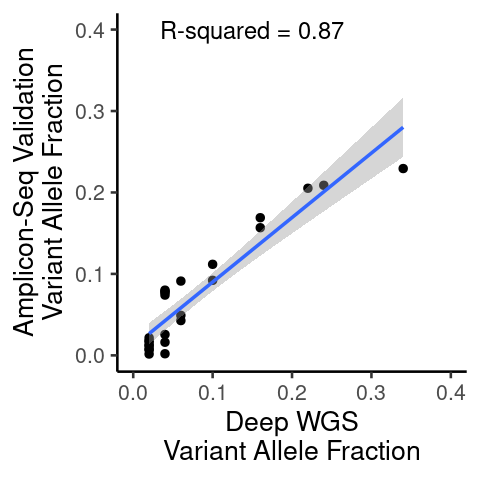

In [17]:
library(tidyverse)
data = read_csv("../data/annotated-calls.csv")

val_vars = read_csv("../resources/variants_to_validate.csv") %>% 
    mutate(id = paste(`Individual ID`, CHROM, POS, REF,ALT,sep = ";")) %>% mutate(val_AF = nALT_val/(nREF_val+nALT_val))
data = data %>% mutate(id = paste(`Individual ID`, CHROM, POS, REF,ALT,sep = ";"))
data$val_frac = val_vars$frac_val[match(data$id, val_vars$id)]
data$val_AF = val_vars$val_AF[match(data$id, val_vars$id)]
data$attempted = val_vars$attempted[match(data$id, val_vars$id)]

options(repr.plot.width = 4, repr.plot.height = 4)


summary(lm(AF ~ val_AF, data=data %>% filter(attempted==1)))$r.squared

p1= data %>% filter(attempted == 1) %>% ggplot(aes(x=AF, y=val_AF)) + 
    geom_point(size=2) + theme_classic(16) +
    ylim(c(0,0.4)) + xlim(c(0,0.4)) + geom_smooth(method="lm") + 
    labs(x = "Deep WGS\nVariant Allele Fraction",y="Amplicon-Seq Validation\nVariant Allele Fraction") +
    annotate(geom="text",label= paste("R-squared =",
                                     round(summary(lm(AF ~ val_AF, data=data %>% filter(attempted==1)))$r.squared,2)),
            x=0.15,y=0.4, size=5)

p1

ggsave(p1, filename = "../figures/validation_figure.pdf",device="pdf",height=4, width=4)

## Figure 1B

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 6426 Columns: 137

── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (47): Individual ID, CHROM, Mutation, REF, ALT, FILTER/PASS, culprit, Ch...
dbl (85): POS, AF, BaseQRankSum, DP, FS, SOR, VQSLOD, szdbCNVcount, GWASpval...
lgl  (5): targetscan_Region Start, targetscan_Region End, targetscan_Item Na...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 86 Columns: 3

── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): ID, Dx
dbl (1): mean_cov


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



ID,Dx,mean_cov
<chr>,<chr>,<dbl>
MSSM_027_NeuN_pl,SCZ,256.1440
MSSM_055_NeuN_pl,SCZ,287.7580
MSSM_056_NeuN_pl,SCZ,123.4260
MSSM_069_NeuN_pl,SCZ,59.6804
MSSM_097_NeuN_pl,SCZ,444.0040
MSSM_099_NeuN_pl,SCZ,309.5520


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



Dx,avg_cov,max_cov,min_cov,median_cov
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Control,245.3304,503.417,59.6804,244.489
SCZ,224.4498,532.064,52.2932,232.637


[1] 267.805


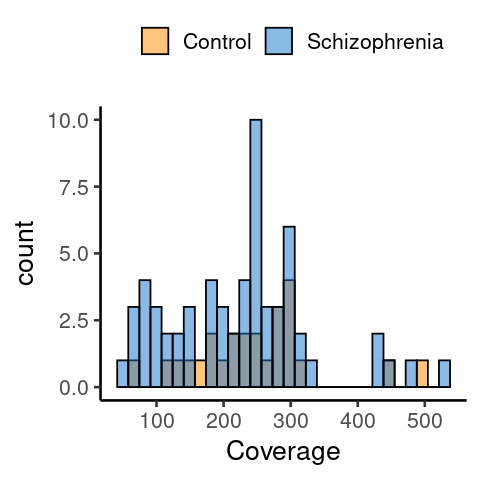

In [18]:
library(tidyverse)
data = read_csv("../data/annotated-calls.csv")
data = data %>% filter(AF < 0.40, Dx != "ASD")

# data1 = read_csv("../data/annotated-calls.csv") %>% filter(Dataset == "Chess")
# data2 = read_csv("../data/annotated-calls_2.csv") %>% filter(Tissue == "NeuN_pl")
# data1 = data1 %>% mutate(id = paste(`Individual ID`, CHROM, POS, Mutation,sep = ";"))
# data2 = data2 %>% mutate(id = paste(`Individual ID`, CHROM, POS, Mutation, sep=";"))
# data1$AD_frac = data2$AD_frac[match(data1$id, data2$id)]

# data=data1 %>% filter(AD_frac < 0.40)

## Get hte coverage information
cov_info = read_tsv("../data/BSM_MSSM_SCZ_coverage.txt", col_names = c("ID","Dx","mean_cov"))
head(cov_info)

data = data %>% mutate(subjectID = str_split(`Individual ID`,"_",n=2,simplify=TRUE)[,2]) 
cov_info$subjectID = unlist(lapply(strsplit(cov_info$ID,"_"), function(x) {paste(x[1:2],collapse="_")}))

data$mean_cov = cov_info$mean_cov[match(data$subjectID,cov_info$subjectID)]

## Check coverage in cases vs control
options(repr.plot.width = 4, repr.plot.height = 4)
data = data %>% filter(Dataset == "Chess")

p1 = data %>% distinct(`Individual ID`,`.keep_all` = TRUE) %>% ggplot(aes(x=mean_cov)) +
    geom_histogram(position="identity",aes(fill=Dx),color="black", alpha=0.5) + 
    theme_classic(base_size=16) +
    scale_fill_manual(values = c("darkorange","dodgerblue3"), labels=c("Control","Schizophrenia")) + 
    labs(x = "Coverage", fill="") +
    theme(legend.position = "top")
p1

data %>% distinct(`Individual ID`,`.keep_all` = TRUE) %>% group_by(Dx) %>% 
    summarise(avg_cov = mean(mean_cov), max_cov = max(mean_cov), min_cov = min(mean_cov), median_cov = median(mean_cov))
print(median(data$mean_cov))
# ggsave(p1,filename = "../figures/coverage_histogram.pdf",device="pdf",width=4,height=4)

## Figure 1D, E

In [19]:
library(tidyverse)
data = read_csv("../data/annotated-calls.csv")
data = data %>% filter(AF < 0.40, Dx != "ASD")
cov_info = read_tsv("../data/BSM_MSSM_SCZ_coverage.txt", col_names = c("ID","Dx","mean_cov"))
data = data %>% mutate(subjectID = str_split(`Individual ID`,"_",n=2,simplify=TRUE)[,2]) 
cov_info$subjectID = unlist(lapply(strsplit(cov_info$ID,"_"), function(x) {paste(x[1:2],collapse="_")}))

data$mean_cov = cov_info$mean_cov[match(data$subjectID,cov_info$subjectID)]
data = data %>% filter(Dataset == "Chess")
data = data %>% mutate(alt_num = ceiling(AF*DP), AF = alt_num/DP)

## Total number of variants
nrow(data)

## Range of variant allele fraction
range(data$AF)

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 6426 Columns: 137

── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (47): Individual ID, CHROM, Mutation, REF, ALT, FILTER/PASS, culprit, Ch...
dbl (85): POS, AF, BaseQRankSum, DP, FS, SOR, VQSLOD, szdbCNVcount, GWASpval...
lgl  (5): targetscan_Region Start, targetscan_Region End, targetscan_Item Na...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 86 Columns: 3

── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): ID, Dx
dbl (1): mean_cov


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



[1] 3284

[1] 0.020000 0.384106

In [20]:
install.packages("gghalves")

Installing package into ‘/home/eam63/R-4.1.1-IRkernel/library’
(as ‘lib’ is unspecified)



In [21]:
options(repr.plot.width = 6, repr.plot.height = 6)

library(gghalves)

overall_rate_0 = data %>% 
    group_by(`Individual ID`, Dx, ageOfDeath,`PMI (in hours)`) %>% 
    summarise(muts = n(), avg_DP = median(mean_cov)) %>% ungroup()
n_dx = 61
n_ctrl = 25

data %>% group_by(Dx) %>% summarise(muts = n()) %>% ungroup() %>% mutate( rate = muts/c(n_ctrl,n_dx), ci = 1.96*sqrt(rate/c(n_ctrl,n_dx)))

## Poisson regression w/o hyper mutated individual
summary(glm(muts ~ Dx + scale(ageOfDeath) +
            scale(avg_DP) + scale(`PMI (in hours)`), data=overall_rate_0 %>% filter(muts <150), family = "poisson"))

## Poisson regression w/ whole cohort. 
summary(glm(muts ~ Dx + scale(ageOfDeath) +
            scale(avg_DP) + scale(`PMI (in hours)`), data=overall_rate_0 , family = "poisson"))


p1 = overall_rate_0  %>% ggplot(aes(x=Dx, y=muts)) + 
    geom_jitter(aes(color = Dx), width=0.2, height=0,size=2, alpha=0.2,show.legend = FALSE) +
    stat_summary(aes(color = Dx), fun = "median", geom = "point", size=5, show.legend = FALSE) +
    scale_color_manual(values = c("darkorange","dodgerblue3"), breaks = c("Control","SCZ")) +
    theme_classic(base_size = 16) + labs(y="sSNVs/sample",x="") 


# p1
#ggsave(p1,filename="figures/overall_rate_nowalsh.pdf",device="pdf")

`summarise()` has grouped output by 'Individual ID', 'Dx', 'ageOfDeath'. You can override using the `.groups` argument.



Dx,muts,rate,ci
<chr>,<int>,<dbl>,<dbl>
Control,862,34.48000,2.301811
SCZ,2422,39.70492,1.581296



Call:
glm(formula = muts ~ Dx + scale(ageOfDeath) + scale(avg_DP) + 
    scale(`PMI (in hours)`), family = "poisson", data = overall_rate_0 %>% 
    filter(muts < 150))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-6.7918  -1.5860  -0.4584   1.2930   6.0647  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)              3.36422    0.03638  92.484  < 2e-16 ***
DxSCZ                    0.16409    0.04152   3.952 7.76e-05 ***
scale(ageOfDeath)        0.06632    0.01875   3.537 0.000404 ***
scale(avg_DP)            0.46398    0.01615  28.727  < 2e-16 ***
scale(`PMI (in hours)`) -0.04233    0.01773  -2.387 0.016996 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 1196.09  on 84  degrees of freedom
Residual deviance:  425.11  on 80  degrees of freedom
AIC: 877.5

Number of Fisher Scoring iterations: 4



Call:
glm(formula = muts ~ Dx + scale(ageOfDeath) + scale(avg_DP) + 
    scale(`PMI (in hours)`), family = "poisson", data = overall_rate_0)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-7.2988  -2.0268  -0.5701   1.0479  17.9951  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)              3.35600    0.03608  93.015  < 2e-16 ***
DxSCZ                    0.25894    0.04070   6.362 1.99e-10 ***
scale(ageOfDeath)        0.01611    0.01805   0.892    0.372    
scale(avg_DP)            0.43095    0.01576  27.339  < 2e-16 ***
scale(`PMI (in hours)`) -0.09830    0.01753  -5.607 2.06e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 1502.82  on 85  degrees of freedom
Residual deviance:  779.51  on 81  degrees of freedom
AIC: 1239

Number of Fisher Scoring iterations: 5


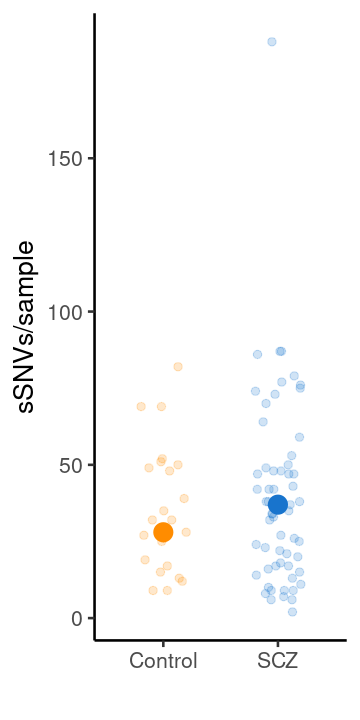

In [22]:
options(repr.plot.width = 3, repr.plot.height = 6)
p1 = overall_rate_0 %>% ggplot(aes(x=Dx, y=muts)) + 
    geom_jitter(aes(color = Dx), width=0.2, height=0,size=2, alpha=0.2,show.legend = FALSE) +
    stat_summary(aes(color=Dx), fun = "median", geom = "point", size=5, show.legend = FALSE) +
    scale_color_manual(values = c("darkorange","dodgerblue3"), breaks = c("Control","SCZ")) +
    scale_fill_manual(values = c("darkorange","dodgerblue3"), breaks = c("Control","SCZ")) +
    theme_classic(base_size = 16) + labs(y="sSNVs/sample",x="") 

p1

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



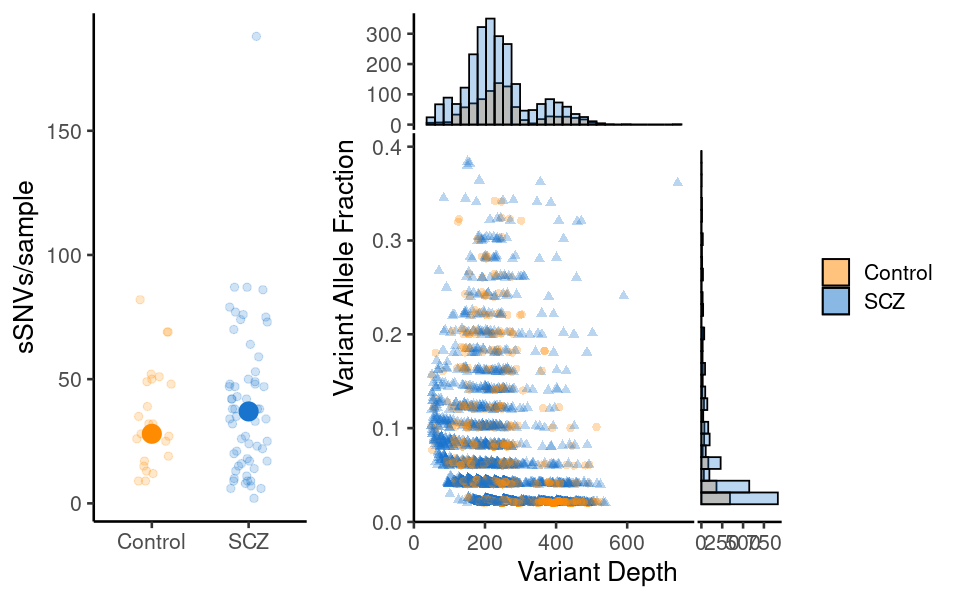

In [23]:
options(repr.plot.width = 8, repr.plot.height = 5)
library(cowplot)
library(ggside)

p2 = data %>% ggplot(aes(x=DP, y=AF)) + geom_jitter(aes(color=Dx, shape=Dx), alpha=0.3, size=2,show.legend=FALSE) + 
    theme_classic(base_size=16) + 
    scale_color_manual(values = c("darkorange","dodgerblue3"), breaks = c("Control","SCZ"))+
    geom_xsidehistogram(position="identity", aes(fill=Dx), color="black", alpha=0.3) +
    geom_ysidehistogram(position="identity", aes(fill=Dx), color="black", alpha=0.3) +
    scale_fill_manual(values = c("darkorange","dodgerblue3"), breaks = c("Control","SCZ")) +
    theme(ggside.panel.scale = 0.3) +
    labs(x="Variant Depth", y = "Variant Allele Fraction", color="", fill="",shape="")



p3 = ggpubr::ggarrange(p1,p2,ncol=2,nrow=1, widths=c(1,2), heights=c(1,2))
p3
# ggsave(p3,filename = "../figures/AF_DP_burden.pdf",device="pdf", height=5, width=8)

In [24]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /n/app/openblas/0.2.19/lib/libopenblas_core2p-r0.2.19.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggside_0.1.3    cowplot_1.1.1   gghalves_0.1.1  forcats_0.5.1  
 [5] stringr_1.4.0   dplyr_1.0.7     purrr_0.3.4     readr_2.1.1    
 [9] tidyr_1.1.4     tibble_3.1.6    ggplot2_3.3.5   tidyverse_1.3.1

loaded via a namespace (and not attached):
 [1] httr_1.4.2          bit64_4.0.5         vroom_1.5.7    